<a href="https://colab.research.google.com/github/chhavisharma/scale/blob/master/ScaleAI_ChhaviSharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [106]:
import os
from google.colab import drive

DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
WORK_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'scaleAI')
os.makedirs(WORK_FOLDER, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Circle Detection

##### Imports and Gloabals

In [107]:
import numpy as np
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import pdb

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# Globals
# loss depends on mac row, col, radius
maxlength = torch.from_numpy(np.array([200.0,200.0,50.0])) 
torch.manual_seed(99)

#Training Routines

##### Data Collection

In [0]:
def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

In [0]:
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]

In [0]:
def collect_data(img_count):
    results = []
    images  = []

    for idx in range(0,img_count):
        params, img = noisy_circle(200, 50, 2)
        images.append(img)
        results.append(params)

    results = np.array(results)
    images = np.array(images)

    return images, results  

def store_data():
  '''
  Roughly collect 80:20 train test data
  with image generation parameters the same 
  as given in the test-main function
  '''
  images, results = collect_data(20000)
  np.save(WORK_FOLDER+'/train_data_20k.npy',images)
  np.save(WORK_FOLDER+'/train_labels_20k.npy',results)
  print('finished train data collection')

  images, results = collect_data(4000)
  np.save(WORK_FOLDER+'/test_data_4k.npy',images)
  np.save(WORK_FOLDER+'/test_labels_4k.npy',results)    
  print('finished test data collection') 

# store_data()

##### Model Definition

In [0]:
class CircleDetector(torch.nn.Module):
  def __init__(self):
    super(CircleDetector, self).__init__()

    # Backbone
    self.conv0    = nn.Conv2d(1, 4, 3, padding=0)
    self.conv0_bn = nn.BatchNorm2d(4, track_running_stats=True)

    self.conv1    = nn.Conv2d(4, 16, 5, padding=0)
    self.conv1_bn = nn.BatchNorm2d(16, track_running_stats=True)

    self.conv2    = nn.Conv2d(16, 32, 5, padding=0) 
    self.conv2_bn = nn.BatchNorm2d(32, track_running_stats=True)
    
    self.conv3    = nn.Conv2d(32,64, 5, padding=0) 
    self.conv3_bn = nn.BatchNorm2d(64, track_running_stats=True)

    self.conv4    = nn.Conv2d(64,128, 5, padding=0) 
    self.conv4_bn = nn.BatchNorm2d(128, track_running_stats=True)

    self.pool1    = nn.MaxPool2d(2, stride=2, padding=0)

    #Down
    self.convInterm    = nn.Conv2d(128, 64, 3, padding=1) 
    self.convInterm_bn = nn.BatchNorm2d(64, track_running_stats=True)

    #Projecting down to Y_hat dims
    self.conv1x4       = nn.Conv2d(64, 3, 2)

  def forward(self, x):

    #Backbone
    x = self.conv0(x) 
    x = self.conv0_bn(x)
    F.relu(x, inplace=True)
    x = self.pool1(x)

 
    x = self.conv1(x) 
    x = self.conv1_bn(x)
    F.relu(x, inplace=True)
    x = self.pool1(x)


    x = self.conv2(x) 
    x = self.conv2_bn(x)
    F.relu(x, inplace=True)
    x = self.pool1(x)

    x = self.conv3(x) 
    x = self.conv3_bn(x)
    F.relu(x, inplace=True)
    x = self.pool1(x)

    x = self.conv4(x) 
    x = self.conv4_bn(x)
    F.relu(x, inplace=True)
    x = self.pool1(x)

    #Intermediate
    x = self.convInterm(x) 
    x = self.convInterm_bn(x)
    F.relu(x, inplace=True)

    # Prediction
    out =  self.conv1x4(x) 
    
    # predict row,col,rad side-normalised
    out = out.squeeze(-1).squeeze(-1)

    return torch.sigmoid(out)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

##### Data Preprocessing

In [9]:
class DatasetProcessed(torch.utils.data.Dataset):
  def __init__(self, data, labels, type="train", transform="None"):
    self.transform = transform
    self.data = data
    self.type = type
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = self.data[idx]
    label = self.labels[idx]

    img = img.astype(np.float32)
    img  = torch.from_numpy(img).unsqueeze(0) # add channel dimension
    label = torch.from_numpy(label)

    if(self.transform != None):
      img = self.transform(img)

    return (img, label)

Norm_shift = [0.5]
FRCNN_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Normalize(Norm_shift, Norm_shift)
                             ])
print('Loading Data')
train_data   = np.load(WORK_FOLDER+'/train_data_20k.npy')
train_label  = np.load(WORK_FOLDER+'/train_labels_20k.npy')
print('Train Loaded')
test_data   = np.load(WORK_FOLDER+'/test_data_4k.npy')
test_label  = np.load(WORK_FOLDER+'/test_labels_4k.npy')
print('Test loaded')

dataset_train = DatasetProcessed(train_data, train_label, "train", None)
dataset_test = DatasetProcessed(test_data, test_label, "test", None)


Loading Data
Train Loaded
Test loaded


In [112]:
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

# Test DataLoader
for bid, (data, target) in enumerate(dataloader_train):
  print(bid)
  print(data.shape)
  print(target.shape)
  break

0
torch.Size([16, 1, 200, 200])
torch.Size([16, 3])


##### Loss Function

In [0]:
def mse(true, pred): #L2
    return ((true - pred)**2).sum()
    
def mae(true, pred): #L1
  return (torch.abs(true - pred)).sum()

def myLossFunction(pred, target, batchsize, scale):

  target = target.type(torch.float64)
  pred = pred.type(torch.float64)
  
  # Loss 
  loss  = mse(pred, target/scale) # side relative predictions
  # loss  = mae(pred, target/scale) # side relative predictions
  
  custom_loss = (loss/batchsize)        
  return custom_loss

##### Training Main

Device:  cuda
Epoch 0/50
Train: epoch 0 [0/20000] current_loss: 0.277133
Train: epoch 0 [1600/20000] current_loss: 0.094334
Train: epoch 0 [3200/20000] current_loss: 0.051533
Train: epoch 0 [4800/20000] current_loss: 0.070740
Train: epoch 0 [6400/20000] current_loss: 0.058868
Train: epoch 0 [8000/20000] current_loss: 0.049518
Train: epoch 0 [9600/20000] current_loss: 0.023098
Train: epoch 0 [11200/20000] current_loss: 0.017326
Train: epoch 0 [12800/20000] current_loss: 0.012537
Train: epoch 0 [14400/20000] current_loss: 0.020707
Train: epoch 0 [16000/20000] current_loss: 0.025743
Train: epoch 0 [17600/20000] current_loss: 0.012012
Train: epoch 0 [19200/20000] current_loss: 0.012955
Train: epoch 0 Average loss: 0.0433
Val:   epoch 0 [0/4000] current_loss: 0.018642
Val:   epoch 0 [400/4000] current_loss: 0.054841
Val:   epoch 0 [800/4000] current_loss: 0.017080
Val:   epoch 0 [1200/4000] current_loss: 0.024986
Val:   epoch 0 [1600/4000] current_loss: 0.007936
Val:   epoch 0 [2000/4000] c

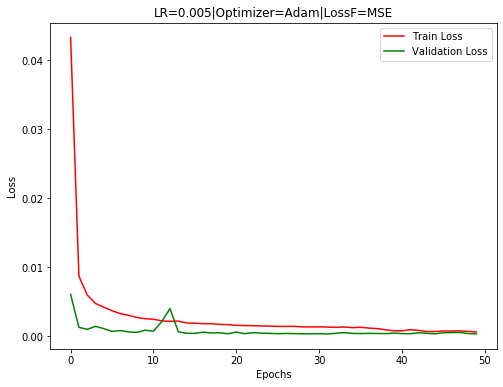

Saving Model.


In [88]:
def logger(logs, logfile, cout='True'):
    if(cout):
      print(logs) 

    with open(logfile, 'a+') as the_file:
      the_file.write(logs+'\n')

def train(model, device, train_loader, optimizer, criterion, epoch, logfile):
  model.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    scale        = maxlength.to(device)
    batch_size   = data.shape[0]
    pred         = model(data)
    loss         = criterion(pred, target, batch_size, scale)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    ## TRACK PROGRESS PER BATCH
    if batch_idx % 100 == 0:
      logs = ('Train: epoch {} [{}/{}] current_loss: {:.6f}'.format(
         epoch, batch_idx*batch_size, len(train_loader.dataset), loss))
      logger(logs, logfile)

  running_loss = running_loss/(len(train_loader)+1) 
  logs = ('Train: epoch {} Average loss: {:.4f}'.format(epoch, running_loss))
  logger(logs, logfile)  

  return running_loss

def val(model, device, test_loader, optimizer, criterion, epoch, logfile):
  model.eval()
  test_loss = 0.0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      
      data, target = data.to(device), target.to(device)
      scale        = maxlength.to(device)      
      batch_size = data.shape[0]
      output       = model(data)
      loss         = criterion(output, target, batch_size, scale)
      test_loss   += loss.item() 
      
      ## TRACK PROGRESS PER BATCH
      if batch_idx % 100 == 0:
        logs = ('Val:   epoch {} [{}/{}] current_loss: {:.6f}'.format(
         epoch, batch_idx*batch_size, len(test_loader.dataset), loss))
        logger(logs, logfile) 
      
  test_loss = test_loss/len(test_loader.dataset)
  logs = ('Val:   epoch {} Average loss: {:.4f}\n'.format(epoch, test_loss))
  logger(logs, logfile) 
  logger('', logfile) 

  return test_loss
  
def training_main(model_name):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # Instantiate your network here:
  model = CircleDetector()
  model = model.to(device)
  
  # Training Configuration:
  num_epochs    = 50
  criterion     = myLossFunction
  learning_rate = 5e-3
  optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Init variables for plots:
  train_loss   = []
  val_loss     = []

  logfile = WORK_FOLDER + '/'+str(model_name)+'_output.txt'

  # Train network:
  print("Device: ",device)

  for epoch in range(num_epochs):
    
    print("Epoch %d/%d" % (epoch, num_epochs))
    avg_train_loss = train(model, device, dataloader_train, optimizer, criterion, epoch, logfile)
    avg_val_loss   = val(model, device, dataloader_test, optimizer, criterion, epoch, logfile)
    
    # Track losses
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)
  
  #Plot
  plt.figure(1,figsize=(8,6))
  plt.plot(np.arange(num_epochs),np.array(train_loss),'-r', label='Train Loss')
  plt.plot(np.arange(num_epochs),np.array(val_loss),'-g', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('LR='+str(learning_rate)+'|Optimizer=Adam'+'|LossF=MSE')
  plt.savefig(WORK_FOLDER+'/LearningCurves_'+str(model_name)+'.png')
  plt.show()

  # UNCOMMENT to save Trained Model State Dict
  print('Saving Model.')
  torch.save(model.state_dict(), WORK_FOLDER + '/' +model_name+'.pth')  
  return model

# TRAIN AGAIN
name = 'model_mse_20k_5e-3_50epochs'
model = training_main(name)
torch.save(model.state_dict(),WORK_FOLDER + '/'+name+'.pth')  

# Run Tests

In [0]:
def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )

In [0]:
def find_circle(img, device, model): 
    # Fill in this function
    img = img.astype(np.float32)
    img  = torch.from_numpy(img).unsqueeze(0) # add channel dimension
    data = img.to(device)

    with torch.no_grad():
      data = data.unsqueeze(0) # batch size 1
      output = model(data)
    
    output = output.cpu() * maxlength
    result = output.numpy().flatten()
    return result

In [116]:
def main():
    print("_____Circle Detection_____")

    #Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trained_model = WORK_FOLDER + '/model_mse_20k_5e-3_50epochs.pth' #'/model_5e-3_50epochs.pth'
    model = CircleDetector()
    print("Device :",device)
    print("Model  : Circle Detector")
    print("Parms  :",count_parameters(model))    
    
    #Load weights
    if(not torch.cuda.is_available()):
        model.load_state_dict(torch.load(trained_model, map_location=lambda storage, loc: storage))
    else:
        model = model.to(device)
        model.load_state_dict(torch.load(trained_model))

    model.eval()

    # Run tests
    results = []
    for _ in range(1000):
        params, img = noisy_circle(200, 50, 2)
        detected = find_circle(img, device, model)
        results.append(iou(params, detected))
    results = np.array(results)

    print("AP over 1000 runs:",(results > 0.7).mean())
    del model

main()

_____Circle Detection_____
Device : cuda
Model  : Circle Detector
Parms  : 345859
AP over 1000 runs: 0.931
